In [1]:
# Loading all relevant modules

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import oom
from src.oom.DiscreteValuedOOM import DiscreteValuedOOM, get_matrices
from src.oom.ContinuousValuedOOM import ContinuousValuedOOM
from src.oom.observable import *
from src.oom.operator import *
from src.oom.util.spectral import get_CQ_by_svd
from src.main import experiment_dimension

sys.modules['oom'] = oom

import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import scipy as sp

from IPython import display
# hdisplay = display.display("", display_id=True)

In [2]:
# Creating some models

n = 3
d = 8
sparsity = 0.9

oom_disc = DiscreteValuedOOM.from_sparse(
    alphabet_size = n,
    dimension = d,
    density = 1 - sparsity,
    deterministic_functional = False,
    stationary_state = False,
    seed = None
)

membership_fns = []
for idx in range(n):
    pdf = sp.stats.uniform(loc = idx / n, scale = 1 / (2 * n))
    membership_fns.append(pdf)

oom_cont = ContinuousValuedOOM(
    dim = oom_disc.dim,
    linear_functional = oom_disc.lin_func,
    operators = oom_disc.operators,
    start_state = oom_disc.start_state,
    membership_functions = membership_fns,
)

In [3]:
# generating a sequence
generation_cont = oom_cont.generate(100000)

In [4]:
generation_cont.keys()

dict_keys(['time_step', 'time_stop', 'state_list', 'nll_list', 'p_vecs', 'mode', 'sequence', 'sequence_cont', 'p_vecs_cont'])

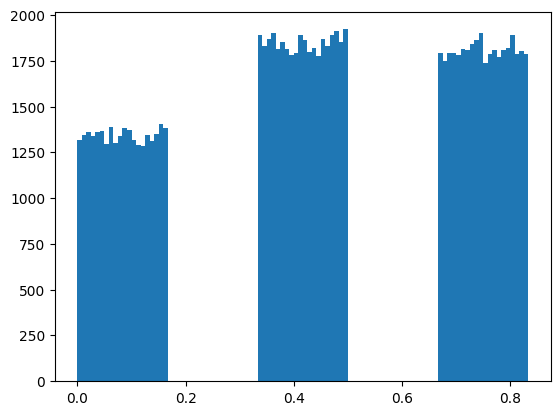

In [5]:
plt.hist(generation_cont.sequence_cont, bins=100)
plt.show()

In [6]:
alphabet = oom_cont.observables
alphabet

[Oa, Ob, Oc]

In [7]:
mfs = oom_cont.membership_fns
mfs

In [8]:
print(generation_cont.sequence_cont[:9])

[0.010842052858462107, 0.04184578744526738, 0.10672856221460877, 0.7179044205242235, 0.707103603248362, 0.8020457725867485, 0.6723872802820914, 0.07715774238996079, 0.3638549416919345]


In [9]:
def estimate(cv_sequence, zbar, memberships):
    """
    Computes the system function estimate for a given continuous-valued sequence and known
    membership functions, using the Ergodic Theorem for Strictly Stationary Processes

    Args:
        cv_sequence: the continuous-valued sequence
        zbar: a word formed of finitely many objects in the alphabet of a symbolic process
        memberships: dictionary linking each alphabet entry to its known membership function
    """
    est = 0
    
    for start in range(len(cv_sequence) - len(zbar) + 1):
        est_here = 1

        # print(f"est_here: {est_here} ", end='')
        
        for idx in range(0, len(zbar)):
            mf = memberships[zbar[idx]]
            x = cv_sequence[start + idx]
            est_here *= mf.pdf(x)
            # print(f"{est_here} ", end='')

        est += est_here / (len(cv_sequence) - len(zbar) + 1)

    return est

In [10]:
mfn_dict = dict(zip(oom_cont.observables, oom_cont.membership_fns))
mfn_dict

{Oa: <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2bc72072600>,
 Ob: <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2bc511a4a40>,
 Oc: <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2bc71ee0770>}

In [ ]:
import itertools # permutations

for perm in itertools.product(oom_cont.observables, repeat = 3):
    print(perm, ':', estimate(generation_cont.sequence_cont, perm, mfn_dict))

In [11]:
len_cwords = 2
len_iwords = 1
alphabet = oom_cont.observables

F_IJ_bl = dict(zip(
    [0] + alphabet,
    [np.zeros(shape = (len(alphabet) ** len_iwords, len(alphabet) ** len_cwords))
     for _ in range(len(alphabet) + 1)]
))

F_0J_bl = np.zeros(shape = (1, len(alphabet) ** len_cwords))

F_I0_bl = np.zeros(shape = (len(alphabet) ** len_iwords, 1))

for idxc, cword in enumerate(itertools.product(alphabet, repeat = len_cwords)):
    F_0J_bl[0, idxc] = estimate(generation_cont.sequence_cont[:1000], cword, mfn_dict)
    
    for idxq, qword in enumerate(itertools.product(alphabet, repeat = len_iwords)):
        F_IJ_bl[0][idxq, idxc] = estimate(generation_cont.sequence_cont[:1000], cword + qword, mfn_dict)
        print(f"{F_IJ_bl[0][idxq, idxc] : <.10f}", cword, qword)
        
        for obs in alphabet:
            F_IJ_bl[obs][idxq, idxc] = estimate(generation_cont.sequence_cont[:1000], cword + (obs,) + qword, mfn_dict)
            print(f"{F_IJ_bl[obs][idxq, idxc] : >12} ", cword, (obs,), qword)

for idxq, qword in enumerate(itertools.product(alphabet, repeat = len_iwords)):
    F_I0_bl[idxq, 0] = estimate(generation_cont.sequence_cont[:10000], qword, mfn_dict)

3.0300601202 (Oa, Oa) (Oa,)
1.299899699097292  (Oa, Oa) (Oa,) (Oa,)
12.99899699097292  (Oa, Oa) (Ob,) (Oa,)
15.598796389167504  (Oa, Oa) (Oc,) (Oa,)
6.2765531062 (Oa, Oa) (Ob,)
7.799398194583752  (Oa, Oa) (Oa,) (Ob,)
11.699097291875628  (Oa, Oa) (Ob,) (Ob,)
9.099297893681044  (Oa, Oa) (Oc,) (Ob,)
5.6272545090 (Oa, Oa) (Oc,)
9.099297893681044  (Oa, Oa) (Oa,) (Oc,)
11.699097291875628  (Oa, Oa) (Ob,) (Oc,)
9.099297893681044  (Oa, Oa) (Oc,) (Oc,)
7.1422845691 (Oa, Ob) (Oa,)
9.099297893681044  (Oa, Ob) (Oa,) (Oa,)
6.49949849548646  (Oa, Ob) (Ob,) (Oa,)
5.199598796389168  (Oa, Ob) (Oc,) (Oa,)
8.2244488978 (Oa, Ob) (Ob,)
19.49849548645938  (Oa, Ob) (Oa,) (Ob,)
20.79839518555667  (Oa, Ob) (Ob,) (Ob,)
14.298896690070212  (Oa, Ob) (Oc,) (Ob,)
7.3587174349 (Oa, Ob) (Oc,)
14.298896690070212  (Oa, Ob) (Oa,) (Oc,)
22.098294884653964  (Oa, Ob) (Ob,) (Oc,)
24.698094282848547  (Oa, Ob) (Oc,) (Oc,)
8.6573146293 (Oa, Oc) (Oa,)
22.098294884653964  (Oa, Oc) (Oa,) (Oa,)
11.699097291875628  (Oa, Oc) (Ob,) (O

In [12]:
np.set_printoptions(linewidth=120)
print("F_0J")
print(F_0J_bl)
print()

print("F_I0")
print(F_I0_bl)
print()

for key, mat in F_IJ_bl.items():
    print(key)
    print(mat)
    print()

F_0J
[[2.48648649 3.81981982 3.81981982 4.10810811 4.61261261 4.         3.4954955  4.32432432 5.33333333]]

F_I0
[[1.6182]
 [2.1978]
 [2.184 ]]

0
[[ 3.03006012  7.14228457  8.65731463  4.32865731  8.00801603  4.32865731  7.35871743  9.52304609  8.00801603]
 [ 6.27655311  8.2244489   6.70941884 10.38877756  8.44088176  7.14228457  6.27655311 11.03807615 12.12024048]
 [ 5.62725451  7.35871743  7.5751503   9.95591182 11.25450902 12.55310621  7.35871743  5.41082164 11.90380762]]

Oa
[[ 1.2998997   9.09929789 22.09829488  2.5997994  10.39919759 10.39919759 12.99899699  6.4994985  11.69909729]
 [ 7.79939819 19.49849549 15.59879639 11.69909729 20.79839519  6.4994985  18.19859579 22.09829488 15.59879639]
 [ 9.09929789 14.29889669 14.29889669 11.69909729 16.89869609  9.09929789 12.99899699 28.59779338 20.79839519]]

Ob
[[12.99899699  6.4994985  11.69909729 18.19859579 22.09829488 18.19859579 11.69909729 19.49849549 27.29789368]
 [11.69909729 20.79839519 19.49849549 24.69809428  9.09929789 19.

In [13]:
T = np.zeros(shape = (len(alphabet), len(alphabet)))

for idx in range(len(alphabet)):
    for jdx in range(len(alphabet)):
        T[idx, jdx] = sp.integrate.quad(
            lambda x: mfn_dict[alphabet[idx]].pdf(x) * mfn_dict[alphabet[jdx]].pdf(x),
            0, 1
        )[0]

T

array([[6., 0., 0.],
       [0., 6., 0.],
       [0., 0., 6.]])

In [14]:
# https://gist.github.com/ahwillia/9a81c0d091e39e319b4b9ab0919e304b
"""
References:

  - B. Plateau, On the stochastic structure of parallelism and synchronization models for distributed algorithms.
  Perform. Eval. Rev., 13 (1985), pp. 147–154.

  - Dayar, T., & Orhan, M. C. (2015). On vector-Kronecker product multiplication with rectangular factors.
  SIAM Journal on Scientific Computing, 37(5), S526-S543.
"""

from functools import reduce
import numpy as np
import numpy.random as npr
import numba
from numpy.testing import assert_array_almost_equal


def kron_vec_prod(Xs, v, out=None, side="right"):
    """
    Computes matrix-vector multiplication between
    matrix kron(X[0], X[1], ..., X[N]) and vector v.

    Parameters
    ----------
    Xs : list of ndarray
        List of square matrices defining Kronecker
        structure.
    v : ndarray
        Vector to multiply.
    out : ndarray or None
        Output vector.
    side : str
        Either "right" to specify kron(Xs...) @ v
        or "left" to specify v.T @ kron(Xs...).

    Returns
    -------
    out : ndarray
        Vector holding result.
    """

    if (out is None) and (side == "right"):
        out = np.empty(np.prod([X.shape[1] for X in Xs]))
    elif (out is None) and (side == "left"):
        out = np.empty(np.prod([X.shape[0] for X in Xs]))

    if side == "right":
        return _left_kron_vec_prod([X.T for X in Xs], v, out)
    elif side == "left":
        return _left_kron_vec_prod(Xs, v, out)
    else:
        raise ValueError(
            "Expected 'side' option to be 'left' or 'right'.")


@numba.jit(nopython=True)
def _left_kron_vec_prod(Xs, p, q):

    H = len(Xs)
    rs = [X.shape[0] for X in Xs]

    q[:] = p

    ileft = 1
    iright = 1
    for X in Xs[1:]:
        iright *= X.shape[0]

    for h in range(H):

        base_i = 0
        base_j = 0

        z = np.empty((1, rs[h]))
        zp = np.empty((1, rs[h]))

        for il in range(ileft):
            for ir in range(iright):
                ii = base_i + ir
                ij = base_j + ir

                for row in range(rs[h]):
                    z[0, row] = q[ii]
                    ii += iright

                np.dot(z, Xs[h], out=zp)

                for col in range(rs[h]):
                    q[ij] = zp[0, col]
                    ij += iright

            base_i += rs[h] * iright
            base_j += rs[h] * iright

        if (h + 1) != H:
            ileft *= rs[h]
            iright //= rs[h + 1]

    return q


# if __name__ == "__main__":
#     print("Testing...")
#     dims = (2, 3, 4, 3, 2)

#     # Left multiplication, square matrices
#     Xs = [npr.randn(s, s) for s in dims]
#     p = npr.randn(np.prod(dims))

#     expected = (p[None, :] @ reduce(np.kron, Xs)).ravel()
#     actual = kron_vec_prod(Xs, p, side="left")

#     assert_array_almost_equal(expected, actual)
#     print("* Passed 1 / 2")

#     # Right multiplication, square matrices
#     Xs = [npr.randn(s, s) for s in dims]
#     p = npr.randn(np.prod(dims))

#     expected = reduce(np.kron, Xs) @ p
#     actual = kron_vec_prod(Xs, p, side="right")

#     assert_array_almost_equal(expected, actual)
#     print("* Passed 2 / 2")

In [15]:
F_IJ_transformed = {}

for key, mat in F_IJ_bl.items():
    mat = mat.flatten()
    reps = len_cwords + len_iwords
    transformed = kron_vec_prod([T for _ in range(reps)], mat, side = "right")
    transformed = transformed.reshape(len(alphabet) ** len_iwords, len(alphabet) ** len_cwords)
    F_IJ_transformed[key] = transformed

F_0J_transformed = kron_vec_prod(
    [T for _ in range(len_cwords)],
    F_0J_bl.flatten(),
    side = "right"
).reshape(
    1,
    len(alphabet) ** len_cwords
)

F_I0_transformed = kron_vec_prod(
    [T for _ in range(len_iwords)],
    F_I0_bl.flatten(),
    side = "right"
).reshape(
    len(alphabet) ** len_iwords,
    1
)

In [16]:
for key, mat in F_IJ_transformed.items():
    print(key, mat, '', sep='\n')
print("col", F_I0_transformed, '', sep='\n')
print("row", F_0J_transformed, '', sep='\n')

0
[[ 654.49298597 1542.73346693 1869.97995992  934.98997996 1729.73146293  934.98997996 1589.48296593 2056.97795591
  1729.73146293]
 [1355.73547094 1776.48096192 1449.23446894 2243.9759519  1823.23046092 1542.73346693 1355.73547094 2384.2244489
  2617.97194389]
 [1215.48697395 1589.48296593 1636.23246493 2150.47695391 2430.9739479  2711.47094188 1589.48296593 1168.73747495
  2571.22244489]]

Oa
[[ 280.77833501 1965.44834504 4773.23169509  561.55667001 2246.22668004 2246.22668004 2807.78335005 1403.89167503
  2527.00501505]
 [1684.67001003 4211.67502508 3369.34002006 2527.00501505 4492.45336008 1403.89167503 3930.89669007 4773.23169509
  3369.34002006]
 [1965.44834504 3088.56168506 3088.56168506 2527.00501505 3650.11835507 1965.44834504 2807.78335005 6177.12337011
  4492.45336008]]

Ob
[[2807.78335005 1403.89167503 2527.00501505 3930.89669007 4773.23169509 3930.89669007 2527.00501505 4211.67502508
  5896.34503511]
 [2527.00501505 4492.45336008 4211.67502508 5334.7883651  1965.44834504 

In [21]:
target_dimension = 3

F_IzJ, F_0J, F_I0 = (F_IJ_transformed, F_0J_transformed, F_I0_transformed)
F_IJ = F_IzJ[0]
C, Q = get_CQ_by_svd(F_IJ, target_dimension)

# Inverse matrix computation
V = C * F_IJ * Q
V_inv = np.linalg.inv(V)

# Get linear functional (learning equation #1)
# It holds that type(sigma) == LinFunctional == np.matrix
sigma = F_0J * Q * V_inv

# Get observable operators (learning equation #2)
tau_z = []
for obsname, F_IkJ in F_IzJ.items():
    if obsname == 0:
        continue
    
    operator_matrix = C * F_IkJ * Q * V_inv
    operator = Operator(obsname,
                        range_dimension = target_dimension,
                        matrix_rep = operator_matrix)
    tau_z.append(operator)
# Get state vector (learning equation #3)
# It holds that type(sigma) == State == np.matrix
omega = C * F_I0

In [22]:
learned_oom = ContinuousValuedOOM(
    dim               = target_dimension,
    linear_functional = sigma,
    operators         = tau_z,
    start_state       = omega,
    membership_functions = oom_cont.membership_fns
)
learned_oom.normalize()

In [23]:
print(learned_oom)

<ContinuousValuedOOM object with dimension 3 and alphabet size 3>
functional = [[ 0.04777957 -0.00483493 -0.00315514]]
start state = [[20.96697281  0.03828964  0.50956841]]^T
alphabet = [Oa, Ob, Oc]
    Oa operator matrix:
[[ 0.28075823 -0.41475389 -0.24757376]
 [ 0.01581025 -0.09941755  0.40719458]
 [ 0.01624774 -0.07879931  0.13769836]]
    Ob operator matrix:
[[ 0.34995958 -0.14993127  0.39759537]
 [-0.04527729 -0.23773472  0.04802617]
 [-0.00430934  0.01937722  0.02667713]]
    Oc operator matrix:
[[ 0.36942514  0.42698515 -0.23064706]
 [ 0.03097272 -0.15883583 -0.52996943]
 [-0.01208112  0.26662224 -0.27077352]]



In [34]:
learned_oom.generate(10).sequence_cont

[0.6799156871850219,
 0.4445977875258379,
 0.40658100483895476,
 0.044840361826411414,
 0.7243472580422022,
 0.7732763492601565,
 0.701872876940559,
 0.4579619882215233,
 0.052884770083499566,
 0.16522339454212454]